# Eager APIとLazy API

In [1]:
import os

import polars as pl

## 定数定義

In [2]:
INPUT_DATA_PATH = os.path.join('..','..','data','taxi')

## 比較する

eager api

In [3]:
%%time

trips = pl.read_parquet(os.path.join(INPUT_DATA_PATH,'yellow_tripdata_*.parquet'))  # globパターンに基づいて、複数読み取り可能
sum_per_vendor = trips.group_by('VendorID').sum()

income_per_distance_per_vendor = sum_per_vendor.select(
    'VendorID',
    income_per_distance=pl.col('total_amount') / pl.col('trip_distance')
)

top_three = (
    income_per_distance_per_vendor.sort(
        by='income_per_distance',
        descending=True
    )
    .head(3)
)

top_three

CPU times: user 5.95 s, sys: 2 s, total: 7.95 s
Wall time: 1.57 s


VendorID,income_per_distance
i64,f64
1,6.434789
6,5.296493
5,4.731557


lazy api

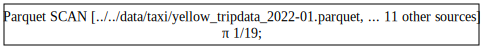

In [4]:
lf = pl.scan_parquet(os.path.join(INPUT_DATA_PATH,'yellow_tripdata_*.parquet'))
lf.select(pl.col('trip_distance')).show_graph()

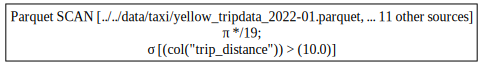

In [5]:
lf.filter(pl.col('trip_distance') > 10).show_graph()

In [6]:
lf.fetch(n_rows=2)

/var/folders/hm/1554tfbj14b8r1wpst4sml2h0000gn/T/ipykernel_58610/1686404431.py:1: DeprecationWarning: `LazyFrame.fetch` is deprecated. `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  lf.fetch(n_rows=2)


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,"""N""",142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,"""N""",236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0


`fetch()`と似ているものに`head()`がある。  
`head()`では完全に計算を実行して結果を出力するが、`fetch()`は最初の行のみを対象にロードして結果の一部を出力する。  
そのため、`fetch(2)`と`head(2)`では得られる結果が同じでも、処理時間では`fetch()`の方が早い。  
ただし、polarsのバージョンアップに伴って、`fetch()`はなくなるらしい（上記のwarningより）

## LazyFrameの最適化

In [7]:
lazy_df = pl.LazyFrame({
    'foo': [1, 2, 3, 4, 5],
    'bar': [6, 7, 8, 9, 10]
})

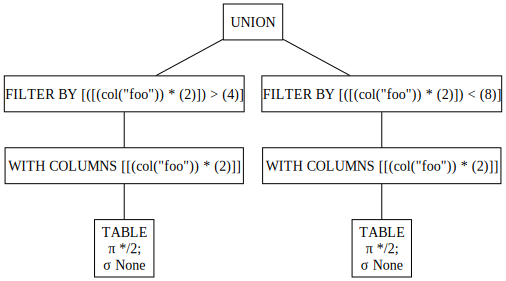

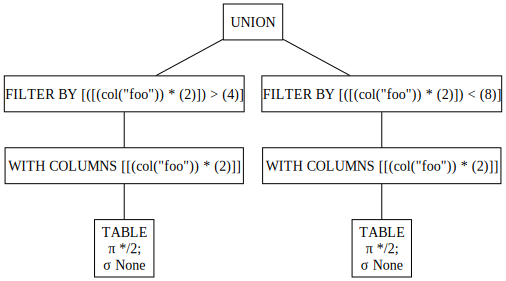

In [8]:
common_subplan = lazy_df.with_columns(pl.col('foo') * 2)

# unittest
expr1 = common_subplan.filter(pl.col('foo') * 2 > 4)
expr2 = common_subplan.filter(pl.col('foo') * 2 < 8)

result = pl.concat([expr1, expr2])

result.show_graph(optimized=False)
result.show_graph()

In [9]:
pl.show_versions()

--------Version info---------
Polars:              1.10.0
Index type:          UInt32
Platform:            macOS-14.6.1-arm64-arm-64bit
Python:              3.12.3 (main, Apr 15 2024, 17:43:11) [Clang 17.0.6 ]
LTS CPU:             False

----Optional dependencies----
adbc_driver_manager  <not installed>
altair               <not installed>
cloudpickle          <not installed>
connectorx           <not installed>
deltalake            <not installed>
fastexcel            <not installed>
fsspec               <not installed>
gevent               <not installed>
great_tables         <not installed>
matplotlib           <not installed>
nest_asyncio         1.6.0
numpy                2.1.2
openpyxl             <not installed>
pandas               2.2.3
pyarrow              <not installed>
pydantic             <not installed>
pyiceberg            <not installed>
sqlalchemy           <not installed>
torch                <not installed>
xlsx2csv             <not installed>
xlsxwriter           <

今使っている`polars==1.10.0`だと、最適化の前後における変化がなかった。  
今回の最適化では、LazyFrameの操作時に共通の処理がある場合は、それらが同一の処理として1つ以外削除されるということが期待された。つまり、共通の処理は最適化によって1つにまとめられるため、それを再利用することで効率的になるということ

eager APIは通常、内部でlazy APIを呼び出して即座に実行しているだけらしい。  
場合によってはeager APIだけでも十分効果を発揮できる場面がありそう

## 最適化その2

In [10]:
ldf = pl.LazyFrame({
    'name': ['Alice', 'Bob', 'Charlie'],
    'age': [25, 30, 35]
})

erroneous_query = ldf.with_columns(
    pl.col('age').str.slice(1, 3).alias('sliced_age')
)

result_df = erroneous_query.collect()

SchemaError: invalid series dtype: expected `String`, got `i64`

lazy APIによって実行直前にエラーを早期発見できる。  
リアルタイムな処理だと、しばらく実行した後にエラーになることがあるため、より早くフィードバックが返ってくることで作業効率が上がる。

## パフォーマンスの違い

In [11]:
%%time

trips = pl.scan_parquet(os.path.join(INPUT_DATA_PATH,'yellow_tripdata_*.parquet'))
sum_per_vendor = trips.group_by('VendorID').sum()
income_per_distance_per_vendor = sum_per_vendor.select(
    'VendorID',
    income_per_distance=pl.col('total_amount') / pl.col('trip_distance')
)

top_three = income_per_distance_per_vendor.sort(
    by='income_per_distance',
    descending=True
).head(3)

top_three.collect()

CPU times: user 1.11 s, sys: 401 ms, total: 1.51 s
Wall time: 416 ms


VendorID,income_per_distance
i64,f64
1,6.434789
6,5.296493
5,4.731557


DataFrameのときと比べて、totalの処理時間が約5倍速くなってる。これは確かにすごいな。  
データが大きくなるほど、より顕著に体感できるはず

In [12]:
lf = pl.LazyFrame({'col1': [1, 2, 3], 'col2': [4, 5, 6]})

print(lf.collect())
print(lf.with_columns(pl.col('col1')+1).collect())

shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 1    ┆ 4    │
│ 2    ┆ 5    │
│ 3    ┆ 6    │
└──────┴──────┘
shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 2    ┆ 4    │
│ 3    ┆ 5    │
│ 4    ┆ 6    │
└──────┴──────┘


上記の例では、`collect()`を2回実行している。  
こうなってしまうと、1回目の実行は最適化されて実行されるが、2回目の実行でももう一度最適化の処理が走ってしまう。  
そうなると同じ計算処理も再度実行することになってしまう。なんでもかんでも`collect()`すれば良いってわけじゃないのか

## DataFrameとLazyFrameの結合

In [13]:
lf = pl.LazyFrame({'id': [1, 2, 3], 'value1': [4, 5, 6]})
df = pl.DataFrame({'id': [1, 2, 3], 'value2': [4, 5, 6]})

lf.join(df, on='id')

TypeError: expected `other` join table to be a LazyFrame, not a 'DataFrame'

In [14]:
lf.join(df.lazy(), on='id')

### LazyFrameのキャッシュ
LazyFrameを途中で加工したいときは、`.collect().lazy()`という工夫を行うことで、キャッシュに計算処理が保持される。  
これを活用することによって、不必要な計算処理が再度走ることがなくなる

In [15]:
lf = pl.LazyFrame({"col1": [1, 2, 3], "col2": [4, 5, 6]})

lf = lf.collect().lazy()
print(lf.collect())
print(lf.with_columns(pl.col("col1") + 1).collect())

shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 1    ┆ 4    │
│ 2    ┆ 5    │
│ 3    ┆ 6    │
└──────┴──────┘
shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 2    ┆ 4    │
│ 3    ┆ 5    │
│ 4    ┆ 6    │
└──────┴──────┘
